
# Pairwise differences in 100kb windows between male X chromosomes

This notebook compiles data sets with pairwise distances for all male haplotypes. The distances between each pair of individuals are computed using the GWF workflow. 


The data set consists of male X chromosomes from the Simons Genome Diversity project. We exclude males with missing data (as in Mallick et al.) and males not showing the XY karyotype (Lucotte et al. 2018). We further removed African males with evidence of recent European admixture. These are the `exlcuded_populations` in `analysis_globals.py`.

There are two sets of window stats: one set including all data and another set where called archaic segmnets are ignored when computing distances. The columns names for the latter set of statistics have a `_af` suffix (for admixture filtered).

In [1]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

numpy.random.seed(7)

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import variables global to the entire analysis:

In [2]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [3]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Convenience functions:

In [4]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

Plotting setup:

In [5]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

Ignore warnings:

In [6]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

## Load meta data

Easy loading of meta data in a consistent manner across code

In [7]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

Write a file with the analyzed individuals form import into manuscript:

In [8]:
records = list()
for indiv, d in individuals.items():
    if d['Genetic sex assignment'] == 'XY':
        records.append((indiv, d['Population ID'], d['Region']))
analyzed_individuals = (DataFrame.from_records(records, 
                                              columns=['Sample ID', 'Population', 'Region'])
                        .sort_values(by=['Region', 'Population'])
                       )
analyzed_individuals.to_csv(ag.results_dir / 'analyzed_individuals.csv', index=False)

## Load pairwise distances

Read in HDF store made in the GWF workflow:

In [9]:
male_dist_data_chrX = pandas.read_hdf(ag.steps_dir / \
                                      'male_dist_admix_masked_stores/male_dist_data_chrX_100kb.hdf')

Nr individuals included:

In [10]:
len(set(list(male_dist_data_chrX.indiv_1.unique()) + \
        list(male_dist_data_chrX.indiv_2.unique())))


162

## Filter missing data

Distribution of number of possitions in each window where at least one or both sequences in a pair has an uncalled base:

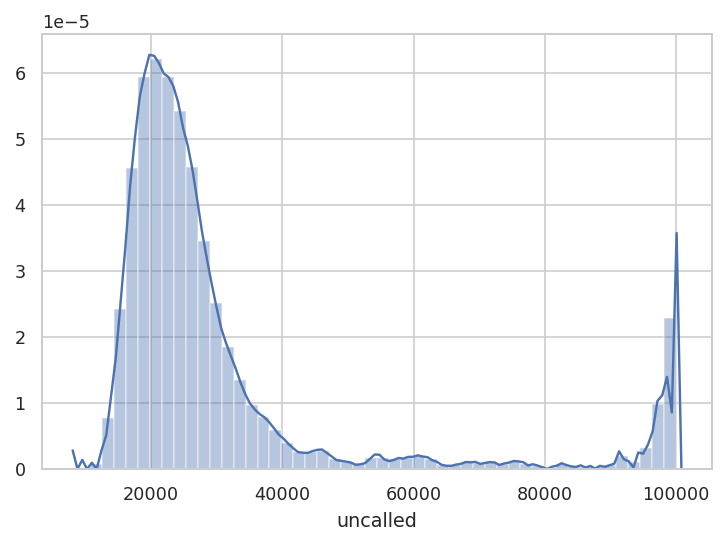

In [11]:
g = sns.distplot(male_dist_data_chrX.uncalled)

In [12]:
print("Cutoff for number of uncalled bases is", ag.max_uncalled_bases)

Cutoff for number of uncalled bases is 50000


In [13]:
enough_called = male_dist_data_chrX.uncalled <= ag.max_uncalled_bases
male_dist_data_chrX.dist.where(enough_called, inplace=True)
male_dist_data_chrX.dist_af.where(enough_called, inplace=True)

## Remove PARs

In [14]:
print(male_dist_data_chrX.dist.isnull().sum())
not_par = (male_dist_data_chrX.start > ag.par1_end) & (male_dist_data_chrX.end < ag.par2_start)
male_dist_data_chrX.dist.where(not_par, inplace=True)
male_dist_data_chrX.dist_af.where(not_par, inplace=True)
print(male_dist_data_chrX.dist.isnull().sum())

2213629
2213629


## Check all windows with data have a defined distance

I.e. that `dist` is never `nan` if `uncalled` is below `max_uncalled_bases`.

In [15]:
assert not (male_dist_data_chrX
            .loc[(male_dist_data_chrX.uncalled <= ag.max_uncalled_bases) & male_dist_data_chrX.dist.isnull()]
            .size
           )

## A test:

In [16]:
def mean_dist(df, dist_col):
    if (df.uncalled > ag.max_uncalled_bases).any():
        # there are uncalled windows in this 500kb so we report 
        # it as nan to indicdate it cannot be called as swept
        return numpy.nan
    else:
        # there are no uncalled windows so we ingnore any windows 
        # with nan dist that are induced by missing data after
        # admixture filtering
        if df[dist_col].isnull().sum() > 2:
            # but return nan if there are more than TWO such windows
            return numpy.nan
        return df[dist_col].mean()
    
df = DataFrame(dict(dist=[1, 1, 1, 1, 1, 2],
                    dist_af=[1, 1, numpy.nan, numpy.nan, 1, 2],
                    uncalled=[0, 0, 0, 0, 0, 0]))
mean_dist(df, 'dist'), mean_dist(df, 'dist_af')

(1.1666666666666667, 1.25)

## Differences between standard analysis and admixture filtered analysis

In [17]:
male_dist_data_chrX.dist.isnull().sum() - (male_dist_data_chrX.uncalled > ag.max_uncalled_bases).sum()

0

In [18]:
male_dist_data_chrX.dist_af.isnull().sum() - (male_dist_data_chrX.uncalled > ag.max_uncalled_bases).sum()

76310

How many extra bases are masked out in filtered analysis:

In [19]:
diff = (male_dist_data_chrX.match + male_dist_data_chrX.mismatch) - (male_dist_data_chrX.match_af + male_dist_data_chrX.mismatch_af)
diff.describe()

count    2.023963e+07
mean     9.203658e+02
std      7.035102e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.993900e+04
dtype: float64

In [20]:
diff[diff > 0].median()

36418.0

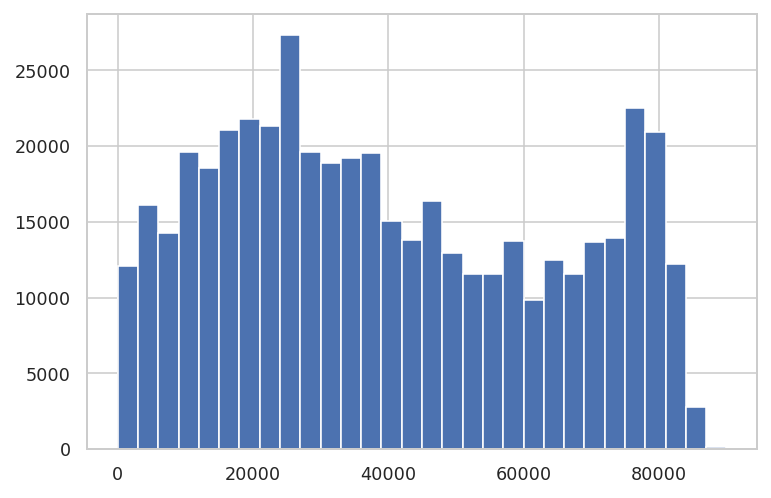

In [21]:
plt.hist(diff[diff > 0], bins=30) ;

In how many extra windows fall does admixture filtering make me unable to compute a distance:

In [22]:
male_dist_data_chrX.dist_af.isnull().sum() - male_dist_data_chrX.dist.isnull().sum()

76310

In [23]:
(male_dist_data_chrX.dist_af.isnull().sum() - male_dist_data_chrX.dist.isnull().sum()) / male_dist_data_chrX.dist.isnull().sum()

0.03447280461179358

How many genomic windows does that affect:

In [24]:
plot_df = (male_dist_data_chrX
           .loc[male_dist_data_chrX.dist_af.isnull() & ~male_dist_data_chrX.dist.isnull()]
           .groupby(['start', 'end']).chrom
           .count()
           .reset_index()
           .sort_values(by='start')
          )

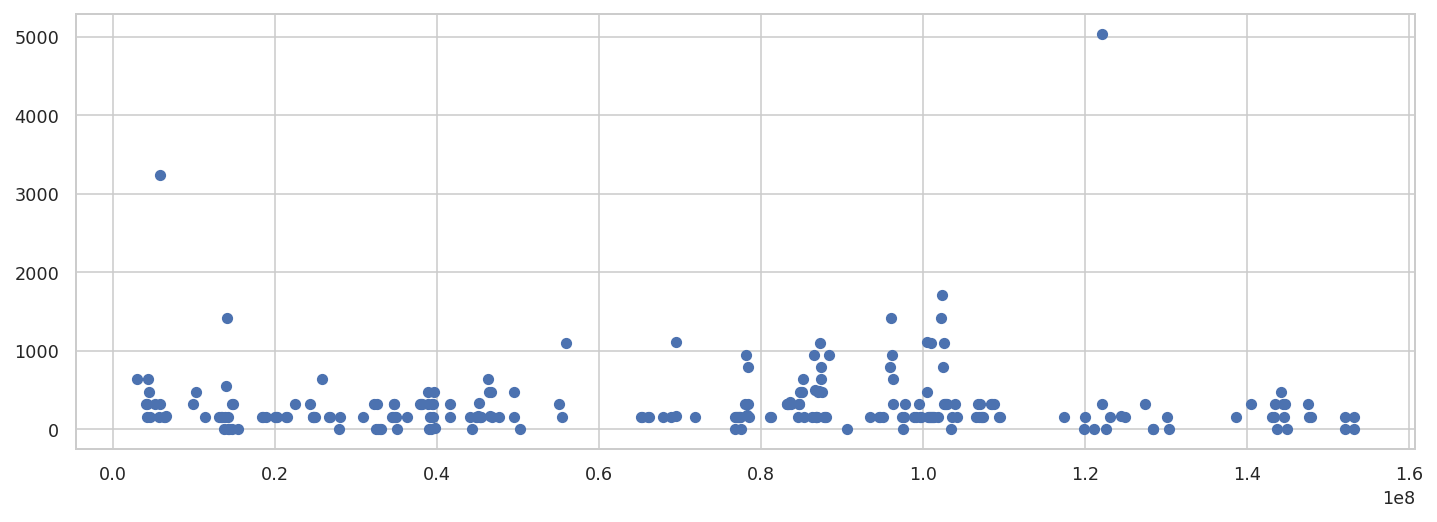

In [25]:
plt.figure(figsize=(12, 4))
plt.scatter(plot_df.start, plot_df.chrom) ;

## Distribution of distances Africa and non-Africa

Here we compare the distributions of pairwise distances for Africans and non-Africans. We make a column `is_oaa` to label group non-African individuals:

In [26]:
plot_df = (male_dist_data_chrX
           .assign(afr_pair=(male_dist_data_chrX.region_1 == 'Africa') & (male_dist_data_chrX.region_2 == 'Africa'),
                   nonafr_pair=(male_dist_data_chrX.region_1 != 'Africa') & (male_dist_data_chrX.region_2 != 'Africa'))
           .loc[lambda df: df.afr_pair | df.nonafr_pair]
           .assign(is_ooa=lambda df: df.region_1 != 'Africa')
          )

len(plot_df), plot_df.is_ooa.sum()

(15459472, 15100960)

Get the number of pairwise differences that are above and below our cutoff for pairwise distance:

In [27]:
(plot_df
 .assign(below_cut=lambda df: df['dist'] <= ag.pwdist_cutoff)
 .groupby(['below_cut', 'is_ooa'])
 .size()
)

below_cut  is_ooa
False      False       352394
           True      12921658
True       False         6118
           True       2179302
dtype: int64

Do the same for the admixture filtered distances:

In [28]:
(plot_df
 .assign(below_cut=lambda df: df['dist_af'] <= ag.pwdist_cutoff)
 .groupby(['below_cut', 'is_ooa'])
 .size()
)

below_cut  is_ooa
False      False       352365
           True      12898660
True       False         6147
           True       2202300
dtype: int64

Plot the distribution of distances:

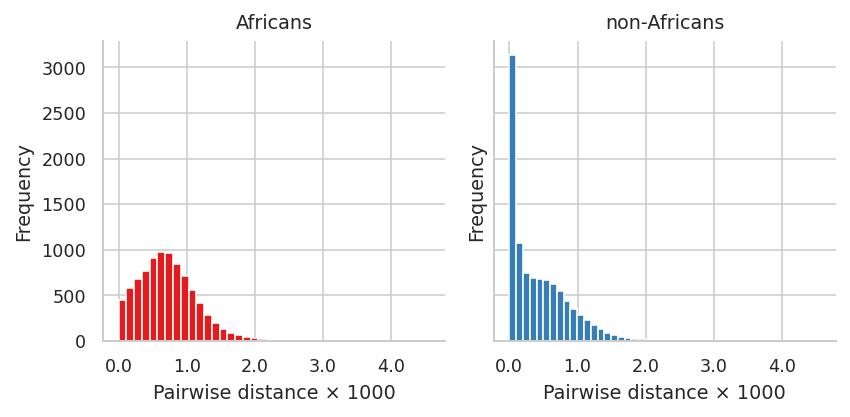

In [29]:
with sns.plotting_context('paper'):
    with sns.axes_style('whitegrid'):
        g = sns.FacetGrid(plot_df, 
                          col="is_ooa",  hue="is_ooa",
                          palette='Set1')
        g = g.map(plt.hist, "dist", density=True, bins=40)
                        
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
            
        for ax in g.axes.flat:
            ax.set_xlabel('Pairwise distance × 1000')
            ax.set_ylabel('Frequency')

            titles = {'True': 'non-Africans', 'False': 'Africans'}
            ax.set_title(titles[ax.get_title()])
            
            def format_func(value, tick_number):
                return str(value*1000)

            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

        plt.tight_layout()

In [30]:
#len(plot_df.loc[(plot_df.dist >= 0.002) & (plot_df.region_1 == 'Africa')])
len(plot_df.loc[(plot_df.dist >= 0.002)])

55616

In [31]:
hist_cut = 0.002

#plot_df['trunc_dist'] = plot_df.dist.where(plot_df.dist <= hist_cut, hist_cut)

plot_df['trunc_dist'] = plot_df.dist
plot_df.loc[plot_df.dist > hist_cut, 'trunc_dist'] = hist_cut


In [32]:
len(plot_df.loc[(plot_df.trunc_dist >= 0.002)])

55616

In [33]:
len(plot_df)

15459472

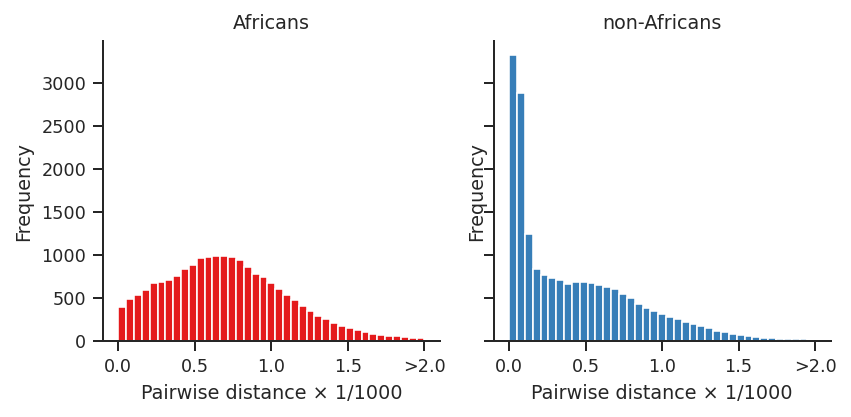

In [34]:
with sns.plotting_context('paper'):
#     with sns.axes_style('whitegrid', {'axes.grid' : False}):
    with sns.axes_style('ticks'):
        g = sns.FacetGrid(plot_df, 
                          col="is_ooa",  hue="is_ooa",
                          palette='Set1')
        g = g.map(plt.hist, "trunc_dist", density=True, bins=numpy.linspace(0, 2e-3, num= 2e-3 / 5e-5))
                        
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
            
        for ax in g.axes.flat:
            ax.set_xlabel('Pairwise distance × 1/1000')
            ax.set_ylabel('Frequency')

            titles = {'True': 'non-Africans', 'False': 'Africans'}
            ax.set_title(titles[ax.get_title()])
            
            def format_func(value, tick_number):
                lab = str(value*1000)
                if value == hist_cut:
                    return '>{}'.format(lab)
                return lab

            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

        plt.tight_layout()
        
        plt.savefig(str(ag.figures_dir / 'distr_dist_afr_nonafr_no_dashed.pdf'))

and a version with a dashed line for the cutoff:

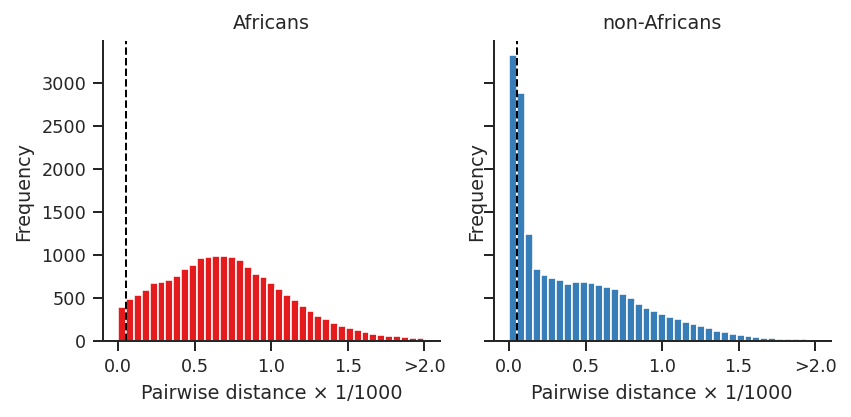

In [35]:
with sns.plotting_context('paper'):
    with sns.axes_style('ticks'):
        g = sns.FacetGrid(plot_df, 
                          col="is_ooa",  hue="is_ooa",
                          palette='Set1')
        g = g.map(plt.hist, "trunc_dist", density=True, bins=numpy.linspace(0, 2e-3, num= 2e-3 / 5e-5))

        for ax in g.axes.flat:
            ax.axvline(ag.pwdist_cutoff, color='black', linestyle='dashed', linewidth=1)
                        
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
            
        for ax in g.axes.flat:
            ax.set_xlabel('Pairwise distance × 1/1000')
            ax.set_ylabel('Frequency')
            
            titles = {'True': 'non-Africans', 'False': 'Africans'}
            ax.set_title(titles[ax.get_title()])
            
            def format_func(value, tick_number):
                lab = str(value*1000)
                if value == hist_cut:
                    return '>{}'.format(lab)
                return lab

            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

        plt.tight_layout()            
            
        plt.savefig(str(ag.figures_dir / 'distr_dist_afr_nonafr.pdf'))
        plt.savefig(str(ag.figures_dir / 'distr_dist_afr_nonafr.png'))

The same plot stratified by region label of indiv_1:

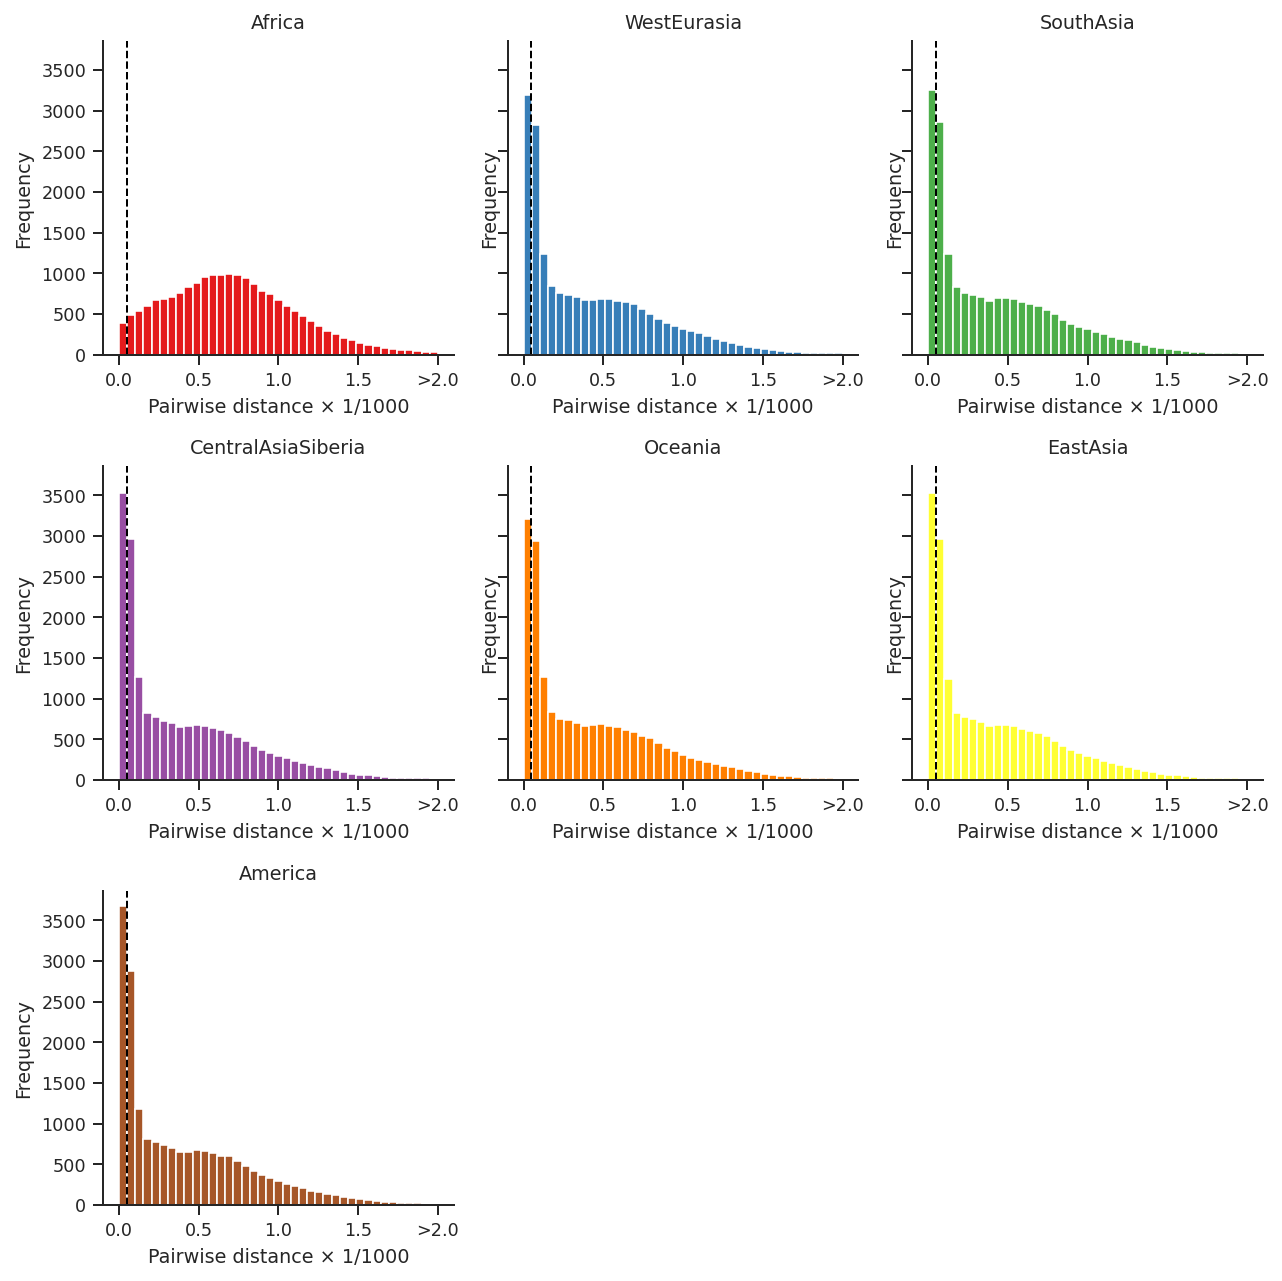

In [36]:
with sns.plotting_context('paper'):
    with sns.axes_style('ticks'):
        g = sns.FacetGrid(plot_df, 
                          col="region_1",  hue="region_1",
                          sharex=False, # to put tics on all x-axes
                          palette='Set1', 
                          col_wrap=3)

        g = g.map(plt.hist, "trunc_dist", density=True, bins=numpy.linspace(0, 2e-3, num= 2e-3 / 5e-5))
        
        for ax in g.axes.flat:
            ax.axvline(ag.pwdist_cutoff, color='black', linestyle='dashed', linewidth=1)
            ax.set_ylabel('Frequency')
            ax.set_xlabel('Pairwise distance × 1/1000')
            
            def format_func(value, tick_number):
                lab = str(value*1000)
                if value == hist_cut:
                    return '>{}'.format(lab)
                return lab

            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))


        g.set_titles(row_template="{row_name}", col_template="{col_name}")
        
        plt.tight_layout()
            
        plt.savefig(str(ag.figures_dir / 'distr_dist_by_indiv_region.pdf'))
        plt.savefig(str(ag.figures_dir / 'distr_dist_by_indiv_region.png'))

Same but with a log x-axis:

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


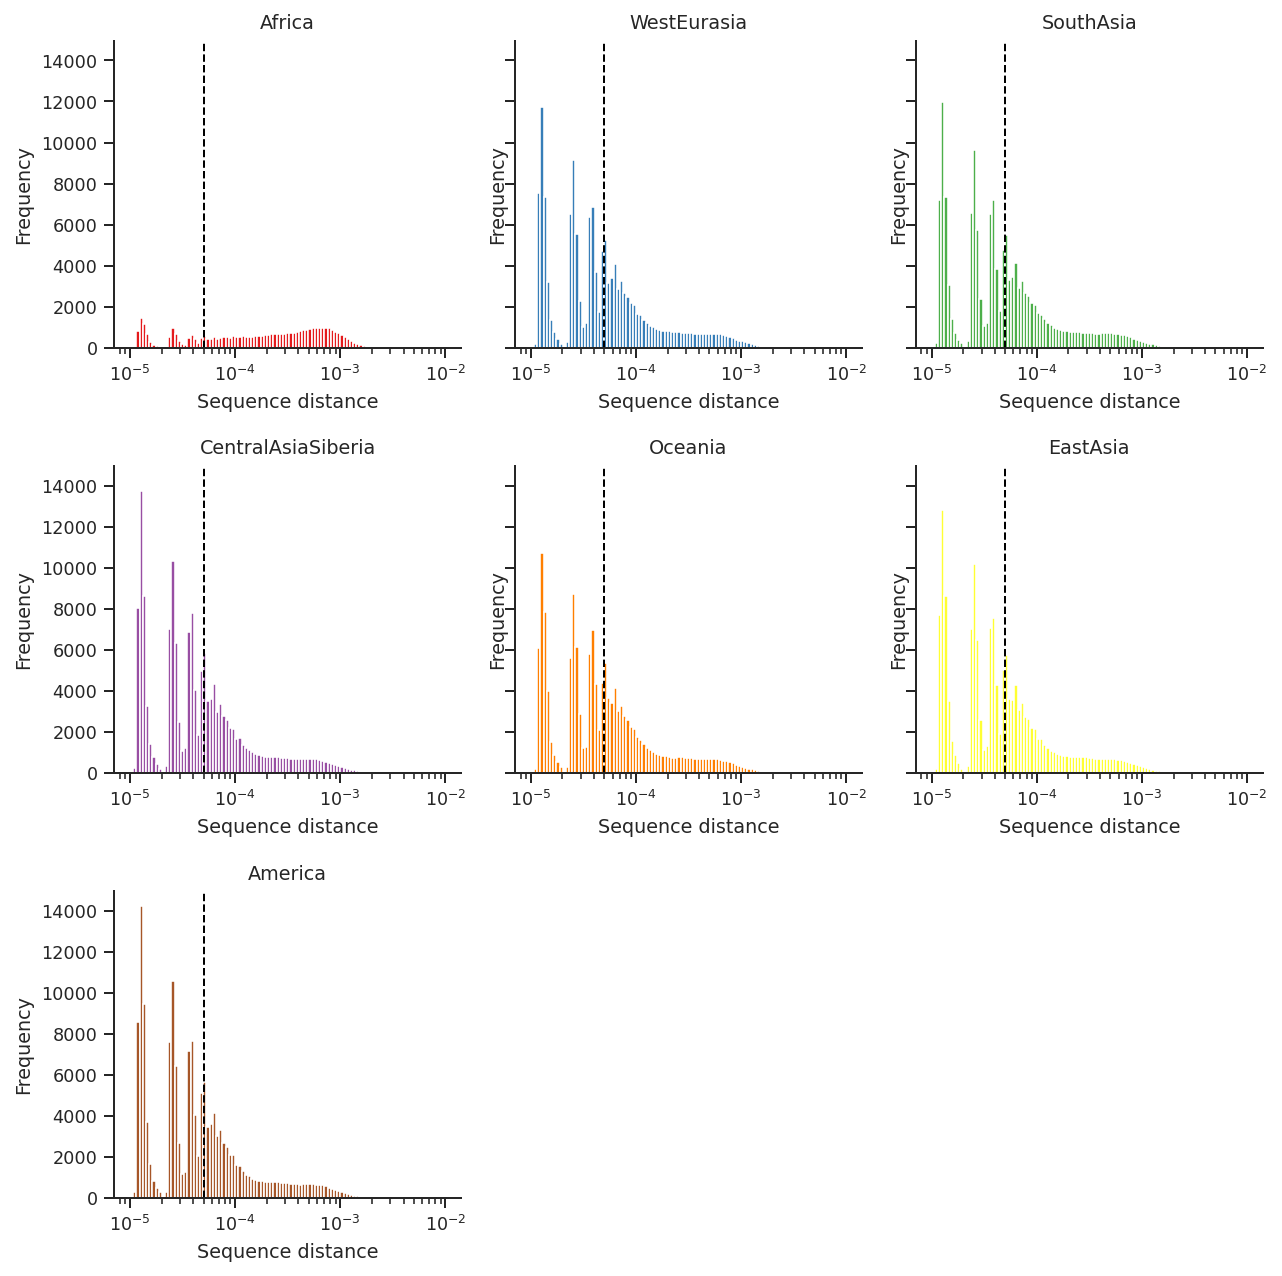

In [37]:
with sns.plotting_context('paper'):
    with sns.axes_style('ticks'):
        g = sns.FacetGrid(plot_df, # all_male_dist_twice.loc[lambda df: df.dist < 0.001], 
                          col="region_1",  hue="region_1",
                          palette='Set1', 
                          sharex=False, # to put tics on all x-axes
                          col_wrap=3)
            
        g = g.map(plt.hist, "dist", density=True, 
                  bins=numpy.logspace(numpy.log10(1e-5),numpy.log10(1e-2), 100)
                 )
        for ax in g.axes.flat:
            ax.axvline(ag.pwdist_cutoff, color='black', linestyle='dashed', linewidth=1)
            ax.set_xscale("log", nonposx='clip')

            ax.set_ylabel('Frequency')
            ax.set_xlabel('Sequence distance')
                
        g.set_titles(row_template="{row_name}", col_template="{col_name}")
        
        plt.tight_layout()
        
        plt.savefig(str(ag.figures_dir / 'distr_dist_by_indiv_region_log.pdf'))
        plt.savefig(str(ag.figures_dir / 'distr_dist_by_indiv_region_log.png'))